## Histopathologic Cancer Detection Using CNN ResNet50 in Fastai

In [34]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import random

from PIL import Image
import PIL.Image

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

from fastai import *
from fastai.vision import *

#Path to load dataset
base_dir = r'F:\School\Sem 3\Neural Network\pcam'

In [35]:
path = Path(base_dir)
path.ls()

[WindowsPath('F:/School/Sem 3/Neural Network/pcam/labels.csv'),
 WindowsPath('F:/School/Sem 3/Neural Network/pcam/models'),
 WindowsPath('F:/School/Sem 3/Neural Network/pcam/pcamv4-stage-1.pth'),
 WindowsPath('F:/School/Sem 3/Neural Network/pcam/sample_submission.csv'),
 WindowsPath('F:/School/Sem 3/Neural Network/pcam/test'),
 WindowsPath('F:/School/Sem 3/Neural Network/pcam/train'),
 WindowsPath('F:/School/Sem 3/Neural Network/pcam/train_labels.csv')]

## Data Exploration

In [36]:
train_path = path/'train'
fnames = get_image_files(train_path)

In [37]:
# Describe labels
data = pd.read_csv(path/'labels.csv')

torch.Size([96, 96])

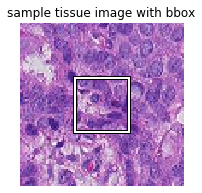

In [38]:
# Sample training image
img = open_image(train_path/'4c9d40a61b0dcdd3a3fec107e8001d430c74a35c.tif')
bbox = ImageBBox.create(*img.size, [[32, 32, 64, 64]])
img.show(y=bbox, title="sample tissue image with bbox")
img.size

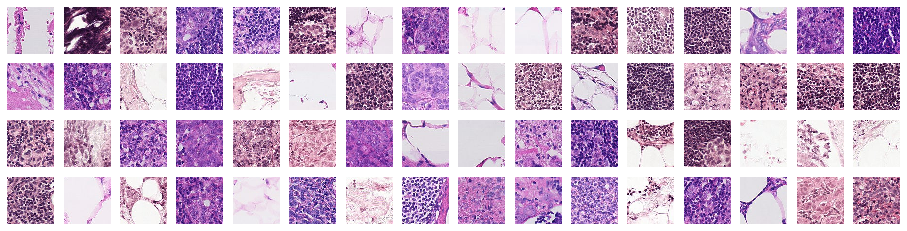

In [39]:
sample_files = random.sample(fnames, 64)

imgs = []
for name in sample_files:
    file_path = os.path.join(train_path, name.parts[-1])
    im = open_image(file_path)
    imgs.append(im)

show_all(imgs,4,16,(16,4))

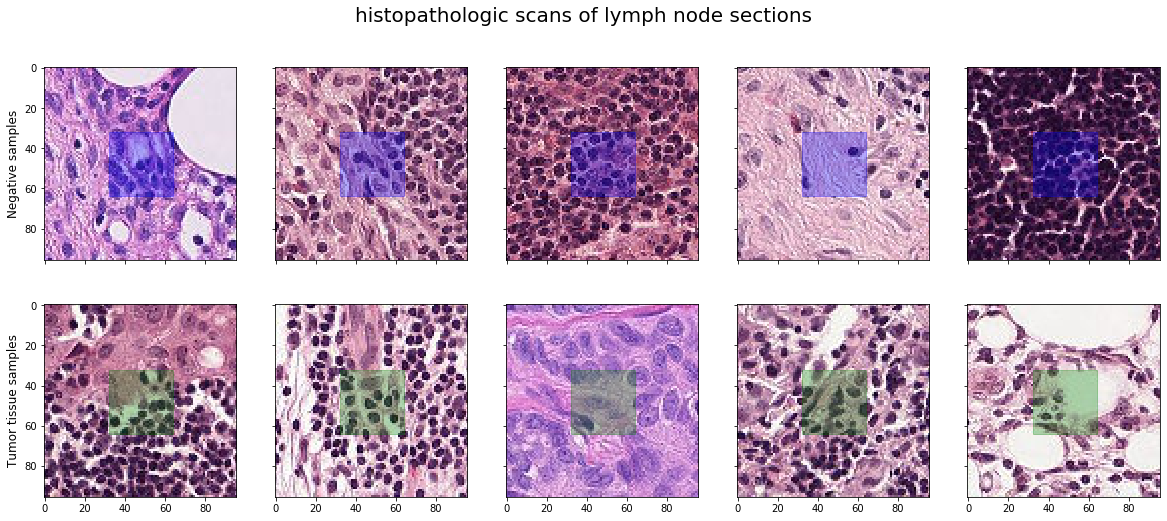

In [40]:
# draw a patch on top for positive and negative results
from PIL import Image

shuffled_data = shuffle(data)

fig, ax = plt.subplots(2, 5, figsize=(20,8), sharex='col', sharey='row')
fig.suptitle("histopathologic scans of lymph node sections", fontsize=20)
    
ax[0, 0].set_ylabel('Negative samples', size='large')
ax[1, 0].set_ylabel('Tumor tissue samples', size='large')

# Negative classes
for i, idx in enumerate(shuffled_data[shuffled_data['label']==0]['id'][:5]):
    file_path = os.path.join(train_path, idx)
    im = Image.open(file_path +'.tif')
    ax[0, i].imshow(im)
    bbox = patches.Rectangle((32,32), 32, 32, color='b', alpha=.3, capstyle='round')
    ax[0, i].add_patch(bbox)

# Positive classes
for i, idx in enumerate(shuffled_data[shuffled_data['label']==1]['id'][:5]):
    file_path = os.path.join(train_path, idx)
    im = Image.open(file_path +'.tif')
    ax[1, i].imshow(im)
    rbox = patches.Rectangle((32,32), 32, 32, color='g', alpha=.3, capstyle='round')
    ax[1, i].add_patch(rbox)

## Data Augmentation

In [8]:
tfms = get_transforms(flip_vert=True)

In [9]:
def get_ex(): 
    return open_image(train_path/'4c9d40a61b0dcdd3a3fec107e8001d430c74a35c.tif')

def plots_f(rows, cols, width, height, **kwargs):
    bbox = ImageBBox.create(*img.size, [[32, 32, 64, 64]])
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax, y=bbox) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

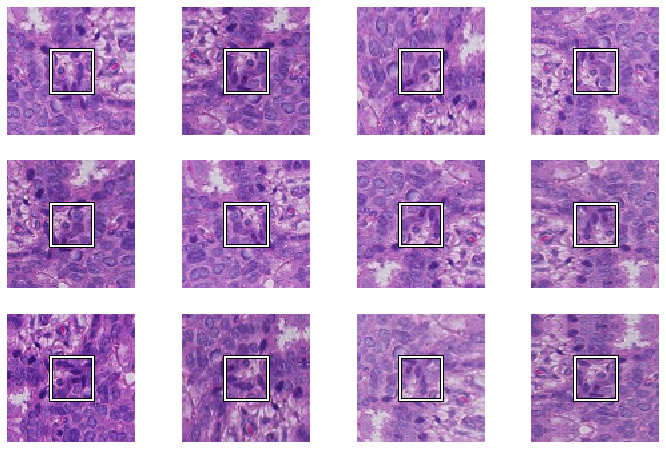

In [10]:
from PIL import Image
from fastai.vision import image
# let's plot a sample image using `tfms` and helper functions defined above
plots_f(3, 4, 12, 8, size=96)

## Creating DataBunch

In [11]:
bs=32
data = ImageDataBunch.from_csv(path, folder='train', test='test', suffix='.tif', ds_tfms=tfms, bs=bs, size=72,num_workers=0)

In [12]:
data.classes

[0, 1]

## Normalization

In [ ]:
data.normalize(imagenet_stats)

In [ ]:
data.show_batch(rows=3, figsize=(6,6), ds_type=DatasetType.Train)

## Transfer Learning using Learner(CNN Restnet50)

In [13]:
# We'll create our learner object with the DataBunch created above and using resnet34 backbone/arch.
# Additionally, we can also specify metrics to see the progress of our learning task
learn = cnn_learner(data, models.resnet50, metrics=accuracy,error_rate, callback_fns=ShowGraph)

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

## Training -  fit_one_cycle

In [15]:
# LR range test that will help you select a good learning rate 
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


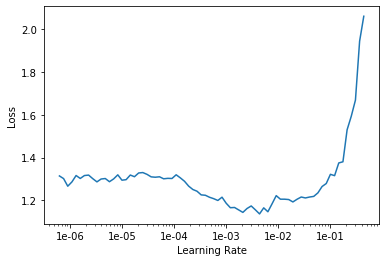

In [16]:
# plot loss vs. learning rate
learn.recorder.plot()

## Freeze

In [17]:
# Using fit_one_cycle() to fit a model using 1cycle policy.
# Traing the model with 4 epoch

learn.fit_one_cycle(4, max_lr=(1e-4, 1e-3, 1e-2), wd=(1e-4, 1e-4, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.312216,0.281766,0.883900,4:05:16
1,0.258125,0.192988,0.925758,6:26:49
2,0.238916,0.182128,0.932076,6:17:14
3,0.217220,0.170738,0.935348,6:22:11


In [24]:
# Save the weights of the trained model
learn.save(base_dir +'stage-1')

In [23]:
preds,y, loss = learn.get_preds(with_loss=True)

# Accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))


The accuracy is 93.53482818603516 %.


## Analyzing Results - Classification Interpretation

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

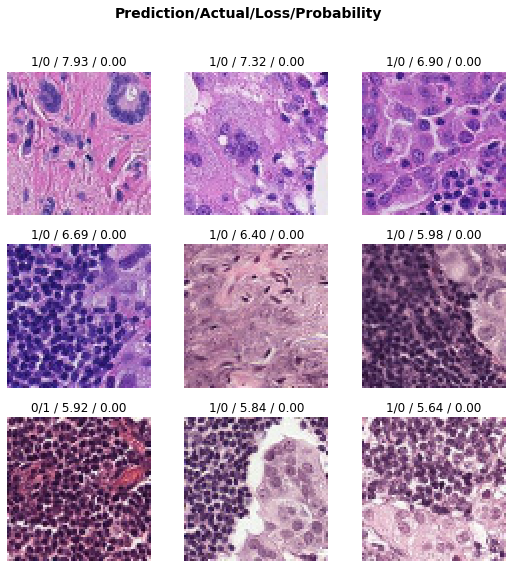

In [26]:
# Visualization of the most incorrect images
interp.plot_top_losses(9, figsize=(9,9))

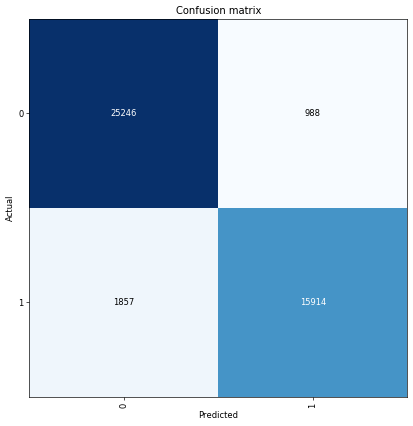

In [27]:
# Plot confusion matrix
interp.plot_confusion_matrix(figsize=(7,7),dpi=60)

## Fine-Tuning

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


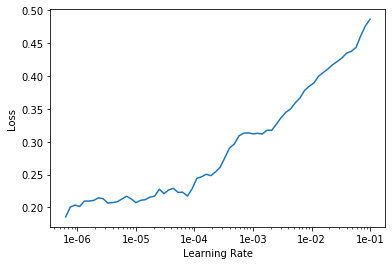

In [28]:
# Unfreeze entire model. https://docs.fast.ai/basic_train.html#Learner.unfreeze
learn.unfreeze()

# fit one cycle after unfreezing all layers
learn.fit_one_cycle(4)

In [ ]:
learn.save(base_dir + 'stage-2')

In [ ]:
preds,y, loss = learn.get_preds(with_loss=True)

# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(9,9))

## Predicting on a Sample test image

In [30]:
img = learn.data.test_ds[0][0]
learn.predict(img)

(Category tensor(1), tensor(1), tensor([0.0030, 0.9970]))

In [31]:
#Test-time-augmentation
preds_t = learn.TTA(ds_type=DatasetType.Test)

In [33]:
# each predictions give probabilty/chance of belonging to pos/neg class for all the test set images.
preds_t[0].shape

torch.Size([57458, 2])